## Датасет FashionMNIST

In [ ]:
# импортируем необходимые библиотеки
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import random

plt.style.use('ggplot')
%matplotlib inline

#сделаем инициализацию random seed,
#чтобы наши эксперименты были воспроизводимы и на других ноутбуках
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
#скачивание датасета для классификации изображений
import torchvision.datasets

FMNIST_train = torchvision.datasets.FashionMNIST('./', download = True, train = True)
FMNIST_test = torchvision.datasets.FashionMNIST('./', download = True, train = False)

100%|██████████| 26421880/26421880 [00:03<00:00, 8292992.40it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 137579.68it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2605515.76it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14280606.48it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
# Разделение выборки на обучащую и тестовую
X_train = FMNIST_train.train_data
y_train = FMNIST_train.train_labels
X_test = FMNIST_test.test_data
y_test = FMNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

tensor(8)


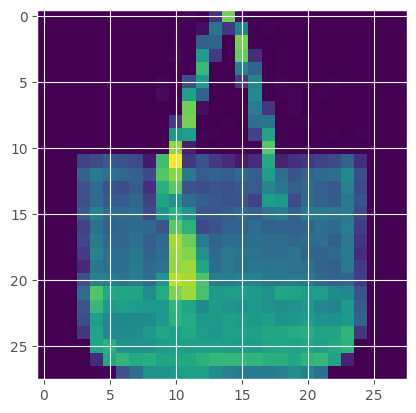

In [ ]:
#посмотрим на картинки
plt.imshow(X_train[35, :, :])
print(y_train[35])

In [ ]:
#у нас трёхмерный тензор, мы хотим двумерный тензор,
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 764 пикселя

X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])
print(X_train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


## Построение полносвязной нейронной сети

In [ ]:
count_col = 28 * 28 # количество признаков

# Создание сети
class FMNISTnet(th.nn.Module):
    def __init__(self, n_neurons):
        super(FMNISTnet, self).__init__()
        # входной слой не пишем, сразу скрытые делаем
        self.fc1 = th.nn.Linear(count_col, n_neurons)
        self.act1 = th.nn.Sigmoid()
        self.fc2 = th.nn.Linear(n_neurons, n_neurons)
        self.act2 = th.nn.Sigmoid()
        self.out = th.nn.Linear(n_neurons, 10)
        self.sm = th.nn.Softmax(dim=1) # выплёвывем вероятность

    def forward(self, x): # проход по построенной сети
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.out(x)
        # софтмакс не юзаем, так как это не обязательно - сеть обучится
        # и на выходах (интерпретация выходов в вероятности не нужна)
        return x # объект, пройденный через нашу нейронку

    def predict(self, data_input):
        with th.no_grad():
            x = self.forward(data_input)
            x = x.reshape(1, -1)
            x = self.sm(x)
            return x

Fmnist_net = FMNISTnet(32)

## Обучение

In [ ]:
# SGD, Momentum (0.9), AdaGrad, RMSProp, Adadelta, Adam, Rprop, LBFGS
SGD_history = []
Momentum_history = []
AdaGrad_history = []
RMSProp_history = []
Adadelta_history = []
Adam_history = []
Rprop_history = []
LBFGS_history = []

### 200 эпох, SGD

$Momentum$ $(\beta = 0)$

$w^{t + 1} = w^t + v^{t + 1}$

$v^{t + 1} = v^t\beta - \alpha\frac{\partial{L}}{\partial{w^t}}$

$\beta \in [0;1]$ $-$ $коэффициент$ $импульса$

In [ ]:
# функция потерь
loss = th.nn.CrossEntropyLoss()

# #оптимизатор
Fmnist_net = FMNISTnet(32)
optimizer = th.optim.SGD(Fmnist_net.parameters(), lr=0.001, momentum=0)

batch_size = 1000 # размер батча (пакета)
epochs = 200 #число эпох

for epoch in range(epochs):
    order = np.random.permutation(len(X_train)) # индексы объектов, отвечает
                                                # за порядок элементов
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad() # делаем, чтоб не добавлял градиенты с прошлой
                              # итерации

        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = Fmnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward() # обратный проход: вычисляем градиенты для
                              # обновления весов
        optimizer.step() # обновление весов

    # test loss
    test_preds = Fmnist_net.forward(X_test)
    SGD_history.append(float(loss(test_preds, y_test)))

    # accuracy
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    print(f'{epoch + 1}: accuracy = {float(accuracy)}')

1: accuracy = 0.1298000067472458
2: accuracy = 0.14030000567436218
3: accuracy = 0.14890000224113464
4: accuracy = 0.15230000019073486
5: accuracy = 0.14390000700950623
6: accuracy = 0.1453000009059906
7: accuracy = 0.147599995136261
8: accuracy = 0.1509999930858612
9: accuracy = 0.15479999780654907
10: accuracy = 0.1582999974489212
11: accuracy = 0.1615999937057495
12: accuracy = 0.16419999301433563
13: accuracy = 0.16820000112056732
14: accuracy = 0.17389999330043793
15: accuracy = 0.1808999925851822
16: accuracy = 0.1899999976158142
17: accuracy = 0.20069999992847443
18: accuracy = 0.21359999477863312
19: accuracy = 0.2312999963760376
20: accuracy = 0.2500999867916107
21: accuracy = 0.2703000009059906
22: accuracy = 0.2944999933242798
23: accuracy = 0.3122999966144562
24: accuracy = 0.33059999346733093
25: accuracy = 0.34880000352859497
26: accuracy = 0.3653999865055084
27: accuracy = 0.3889999985694885
28: accuracy = 0.4025000035762787
29: accuracy = 0.42080000042915344
30: accurac

### 200 эпох, Momentum

$Momentum$

$w^{t + 1} = w^t + v^{t + 1}$

$v^{t + 1} = v^t\beta - \alpha \frac{\partial{L}}{\partial{w^t}}$

$\beta \in [0;1]$ $-$ $коэффициент$ $импульса$

In [ ]:
# функция потерь
loss = th.nn.CrossEntropyLoss()

Fmnist_net = FMNISTnet(32)
# #оптимизатор
optimizer = th.optim.SGD(Fmnist_net.parameters(), lr=0.001, momentum=0.9)

batch_size = 1000 # размер батча (пакета)
epochs = 200 #число эпох

for epoch in range(epochs):
    order = np.random.permutation(len(X_train)) # индексы объектов, отвечает
                                                # за порядок элементов
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad() # делаем, чтоб не добавлял градиенты с прошлой
                              # итерации

        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = Fmnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward() # обратный проход: вычисляем градиенты для
                              # обновления весов
        optimizer.step() # обновление весов

    # test loss
    test_preds = Fmnist_net.forward(X_test)
    Momentum_history.append(float(loss(test_preds, y_test)))

    # accuracy
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    print(f'{epoch + 1}: accuracy = {float(accuracy)}')

1: accuracy = 0.21629999577999115
2: accuracy = 0.3411000072956085
3: accuracy = 0.38510000705718994
4: accuracy = 0.43540000915527344
5: accuracy = 0.48179998993873596
6: accuracy = 0.5289999842643738
7: accuracy = 0.5464000105857849
8: accuracy = 0.5547000169754028
9: accuracy = 0.5644999742507935
10: accuracy = 0.5699999928474426
11: accuracy = 0.5706999897956848
12: accuracy = 0.5620999932289124
13: accuracy = 0.5708000063896179
14: accuracy = 0.5755000114440918
15: accuracy = 0.5769000053405762
16: accuracy = 0.5773000121116638
17: accuracy = 0.5805000066757202
18: accuracy = 0.5863999724388123
19: accuracy = 0.5921000242233276
20: accuracy = 0.593999981880188
21: accuracy = 0.6001999974250793
22: accuracy = 0.598800003528595
23: accuracy = 0.6100000143051147
24: accuracy = 0.6233000159263611
25: accuracy = 0.6370999813079834
26: accuracy = 0.644599974155426
27: accuracy = 0.6438999772071838
28: accuracy = 0.64410001039505
29: accuracy = 0.6462000012397766
30: accuracy = 0.6406000

### 200 эпох, AdaGrad

$AdaGrad$ $(adaptive$ $gradient)$

$g_t = \frac{\partial{L}}{\partial{w_t}}$ $расчёт$ $градиента$

$r_t = r_{t - 1} + g^2_t$ $накапливаем$ $квадраты$ $градиентов$

$w_{t + 1} = w_t - \frac{\alpha}{\epsilon + \sqrt{r_t}} g_t$ $обновляем$ $веса$

$\alpha$ $-$ $заданная$ $в$ $начале$ $скорость$ $обучения$

$\epsilon$ $-$ $очень$ $маленькое$ $значение,$ $которое$ $необходимо$ $только$ $для$ $избежания$
$деления$ $на$ $ноль$

$g_t$ $-$ $градиент$ $на$ $t-ом$ $шаге$

$r$ $-$ $сумма$ $квадратов$ $градиентов,$ $начальное$ $значение$ $равно$ $0$

In [ ]:
# функция потерь
loss = th.nn.CrossEntropyLoss()

Fmnist_net = FMNISTnet(32)
# #оптимизатор
optimizer = th.optim.Adagrad(Fmnist_net.parameters(), lr=0.001)

batch_size = 1000 # размер батча (пакета)
epochs = 200 #число эпох

for epoch in range(epochs):
    order = np.random.permutation(len(X_train)) # индексы объектов, отвечает
                                                # за порядок элементов
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad() # делаем, чтоб не добавлял градиенты с прошлой
                              # итерации

        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = Fmnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward() # обратный проход: вычисляем градиенты для
                              # обновления весов
        optimizer.step() # обновление весов

    # test loss
    test_preds = Fmnist_net.forward(X_test)
    AdaGrad_history.append(float(loss(test_preds, y_test)))

    # accuracy
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    print(f'{epoch + 1}: accuracy = {float(accuracy)}')

1: accuracy = 0.3345000147819519
2: accuracy = 0.6046000123023987
3: accuracy = 0.6674000024795532
4: accuracy = 0.682699978351593
5: accuracy = 0.6825000047683716
6: accuracy = 0.6833999752998352
7: accuracy = 0.6859999895095825
8: accuracy = 0.6814000010490417
9: accuracy = 0.6825000047683716
10: accuracy = 0.6840000152587891
11: accuracy = 0.684499979019165
12: accuracy = 0.6863999962806702
13: accuracy = 0.6873000264167786
14: accuracy = 0.6850000023841858
15: accuracy = 0.6855999827384949
16: accuracy = 0.6850000023841858
17: accuracy = 0.6848999857902527
18: accuracy = 0.6869000196456909
19: accuracy = 0.6891999840736389
20: accuracy = 0.6938999891281128
21: accuracy = 0.6905999779701233
22: accuracy = 0.6919999718666077
23: accuracy = 0.6909999847412109
24: accuracy = 0.694100022315979
25: accuracy = 0.6992999911308289
26: accuracy = 0.7013999819755554
27: accuracy = 0.70169997215271
28: accuracy = 0.7035999894142151
29: accuracy = 0.703499972820282
30: accuracy = 0.704200029373

### 200 эпох, RMSProp


$RMSProp$

$g_t = \frac{\partial{L}}{\partial{w_t}}$ $расчёт$ $градиента$

$r_t = \beta r_{t-1} + (1 - \beta) g^2_t$ $накапливаем$ $квадраты$ $градиентов$

$w_{t + 1} = w_t - \frac{\alpha}{\epsilon + \sqrt{r_t}} g_t$ $обновляем$ $веса$

In [ ]:
# функция потерь
loss = th.nn.CrossEntropyLoss()

Fmnist_net = FMNISTnet(32)
# #оптимизатор
optimizer = th.optim.RMSprop(Fmnist_net.parameters(), lr=0.001)

batch_size = 1000 # размер батча (пакета)
epochs = 200 #число эпох

for epoch in range(epochs):
    order = np.random.permutation(len(X_train)) # индексы объектов, отвечает
                                                # за порядок элементов
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad() # делаем, чтоб не добавлял градиенты с прошлой
                              # итерации

        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = Fmnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward() # обратный проход: вычисляем градиенты для
                              # обновления весов
        optimizer.step() # обновление весов

    # test loss
    test_preds = Fmnist_net.forward(X_test)
    RMSProp_history.append(float(loss(test_preds, y_test)))

    # accuracy
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    print(f'{epoch + 1}: accuracy = {float(accuracy)}')

1: accuracy = 0.42590001225471497
2: accuracy = 0.6442999839782715
3: accuracy = 0.6499000191688538
4: accuracy = 0.6201000213623047
5: accuracy = 0.6952999830245972
6: accuracy = 0.7006000280380249
7: accuracy = 0.6966999769210815
8: accuracy = 0.729200005531311
9: accuracy = 0.7469000220298767
10: accuracy = 0.7565000057220459
11: accuracy = 0.7634000182151794
12: accuracy = 0.7796000242233276
13: accuracy = 0.7626000046730042
14: accuracy = 0.7802000045776367
15: accuracy = 0.7879999876022339
16: accuracy = 0.7973999977111816
17: accuracy = 0.7885000109672546
18: accuracy = 0.798799991607666
19: accuracy = 0.7961999773979187
20: accuracy = 0.7749000191688538
21: accuracy = 0.7903000116348267
22: accuracy = 0.7932000160217285
23: accuracy = 0.8123999834060669
24: accuracy = 0.8022000193595886
25: accuracy = 0.7997999787330627
26: accuracy = 0.7954999804496765
27: accuracy = 0.8108999729156494
28: accuracy = 0.8122000098228455
29: accuracy = 0.7896000146865845
30: accuracy = 0.8080999

### 200 эпох, AdaDelta

$Очень$ $похож$ $на$ $RMSProp$

In [ ]:
# функция потерь
loss = th.nn.CrossEntropyLoss()

Fmnist_net = FMNISTnet(32)
# оптимизатор
optimizer = th.optim.Adadelta(Fmnist_net.parameters(), lr=0.001)

batch_size = 1000 # размер батча (пакета)
epochs = 200 #число эпох

for epoch in range(epochs):
    order = np.random.permutation(len(X_train)) # индексы объектов, отвечает
                                                # за порядок элементов
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad() # делаем, чтоб не добавлял градиенты с прошлой
                              # итерации

        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = Fmnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward() # обратный проход: вычисляем градиенты для
                              # обновления весов
        optimizer.step() # обновление весов

    # test loss
    test_preds = Fmnist_net.forward(X_test)
    Adadelta_history.append(float(loss(test_preds, y_test)))

    # accuracy
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    print(f'{epoch + 1}: accuracy = {float(accuracy)}')

1: accuracy = 0.11299999803304672
2: accuracy = 0.1256999969482422
3: accuracy = 0.14110000431537628
4: accuracy = 0.16439999639987946
5: accuracy = 0.19050000607967377
6: accuracy = 0.21619999408721924
7: accuracy = 0.23340000212192535
8: accuracy = 0.24879999458789825
9: accuracy = 0.2603999972343445
10: accuracy = 0.27239999175071716
11: accuracy = 0.2799000144004822
12: accuracy = 0.29030001163482666
13: accuracy = 0.3003000020980835
14: accuracy = 0.30869999527931213
15: accuracy = 0.3172000050544739
16: accuracy = 0.32359999418258667
17: accuracy = 0.3301999866962433
18: accuracy = 0.33480000495910645
19: accuracy = 0.33889999985694885
20: accuracy = 0.34310001134872437
21: accuracy = 0.34549999237060547
22: accuracy = 0.34850001335144043
23: accuracy = 0.3499999940395355
24: accuracy = 0.35109999775886536
25: accuracy = 0.35409998893737793
26: accuracy = 0.3549000024795532
27: accuracy = 0.3560999929904938
28: accuracy = 0.3571999967098236
29: accuracy = 0.3564999997615814
30: a

### 200 эпох, Adam

$Adam$ $(ADAptive$ $Momentum)$

$m_t = \beta_1m_{t - 1} + (1 - \beta_1)g_t,$ $\hat{m_t} = \frac{m_t}{1 - \beta_1}$

$v_t = \beta_2v_{t - 1} + (1 - \beta_2)g^2_t,$ $\hat{v_t} = \frac{v_t}{1 - \beta_2}$

$w_{t + 1} = w_t - \frac{\alpha}{\epsilon + \sqrt{\hat{v_t}}}\hat{m_t}$

$t$ $-$ $номер$ $итерации$

$g_t$ $-$ $рассчитанный$ $градиент$

$\beta_1$ $и$ $\beta_2$ $-$ $коэффициенты$

$m_t$ $и$ $v_t$ $-$ $скользящее$ $среднее$ $градиента$ $и$ $квадрата$ $градиента$

In [ ]:
# функция потерь
loss = th.nn.CrossEntropyLoss()

Fmnist_net = FMNISTnet(32)
# #оптимизатор
optimizer = th.optim.Adam(Fmnist_net.parameters(), lr=0.001)

batch_size = 1000 # размер батча (пакета)
epochs = 200 #число эпох

for epoch in range(epochs):
    order = np.random.permutation(len(X_train)) # индексы объектов, отвечает
                                                # за порядок элементов
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad() # делаем, чтоб не добавлял градиенты с прошлой
                              # итерации

        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = Fmnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward() # обратный проход: вычисляем градиенты для
                              # обновления весов
        optimizer.step() # обновление весов

    # test loss
    test_preds = Fmnist_net.forward(X_test)
    Adam_history.append(float(loss(test_preds, y_test)))

    # accuracy
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    print(f'{epoch + 1}: accuracy = {float(accuracy)}')

1: accuracy = 0.6055999994277954
2: accuracy = 0.6295999884605408
3: accuracy = 0.7080000042915344
4: accuracy = 0.7189000248908997
5: accuracy = 0.7283999919891357
6: accuracy = 0.72079998254776
7: accuracy = 0.7321000099182129
8: accuracy = 0.7401000261306763
9: accuracy = 0.7390999794006348
10: accuracy = 0.7434999942779541
11: accuracy = 0.7549999952316284
12: accuracy = 0.7645999789237976
13: accuracy = 0.762499988079071
14: accuracy = 0.7736999988555908
15: accuracy = 0.7574999928474426
16: accuracy = 0.7741000056266785
17: accuracy = 0.7774999737739563
18: accuracy = 0.7663999795913696
19: accuracy = 0.76910001039505
20: accuracy = 0.775600016117096
21: accuracy = 0.7652999758720398
22: accuracy = 0.781000018119812
23: accuracy = 0.784500002861023
24: accuracy = 0.7964000105857849
25: accuracy = 0.7919999957084656
26: accuracy = 0.8048999905586243
27: accuracy = 0.7828999757766724
28: accuracy = 0.7864000201225281
29: accuracy = 0.8082000017166138
30: accuracy = 0.81360000371932

### 200 эпох, RProp

In [ ]:
# Rprop 200 эпох

# функция потерь
loss = th.nn.CrossEntropyLoss()

Fmnist_net = FMNISTnet(32)
# оптимизатор
optimizer = th.optim.Rprop(Fmnist_net.parameters(), lr=0.001)

batch_size = 1000
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = Fmnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    # test loss
    test_preds = Fmnist_net.forward(X_test)
    Rprop_history.append(float(loss(test_preds, y_test)))

    # accuracy
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    print(f'{epoch + 1}: accuracy = {float(accuracy)}')

1: accuracy = 0.7394999861717224
2: accuracy = 0.7476000189781189
3: accuracy = 0.7462999820709229
4: accuracy = 0.7472000122070312
5: accuracy = 0.7484999895095825
6: accuracy = 0.7505000233650208
7: accuracy = 0.7513999938964844
8: accuracy = 0.7520999908447266
9: accuracy = 0.753000020980835
10: accuracy = 0.7526000142097473
11: accuracy = 0.7526000142097473
12: accuracy = 0.7534999847412109
13: accuracy = 0.7534000277519226
14: accuracy = 0.7547000050544739
15: accuracy = 0.7548999786376953
16: accuracy = 0.7558000087738037
17: accuracy = 0.7565000057220459
18: accuracy = 0.7562000155448914
19: accuracy = 0.7559999823570251
20: accuracy = 0.7562999725341797
21: accuracy = 0.7566999793052673
22: accuracy = 0.7573000192642212
23: accuracy = 0.7574999928474426
24: accuracy = 0.7577000260353088
25: accuracy = 0.7577999830245972
26: accuracy = 0.7573999762535095
27: accuracy = 0.7572000026702881
28: accuracy = 0.7574999928474426
29: accuracy = 0.7580999732017517
30: accuracy = 0.7584000

## Визуализация результатов

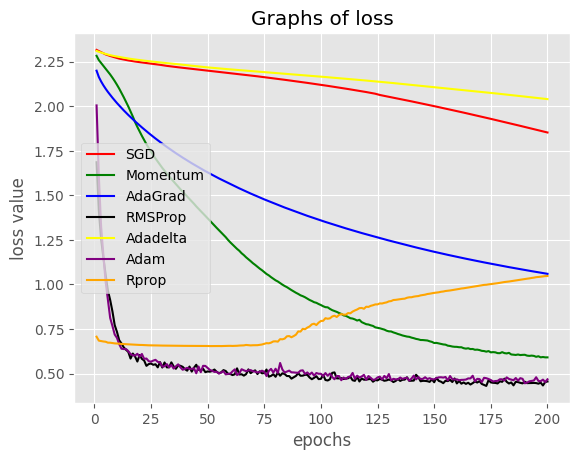

In [ ]:
plt.title('Graphs of loss')
plt.plot(list(range(1, epochs + 1)), SGD_history, color='red', label='SGD')
plt.plot(list(range(1, epochs + 1)), Momentum_history, color='green', label='Momentum')
plt.plot(list(range(1, epochs + 1)), AdaGrad_history, color='blue', label='AdaGrad')
plt.plot(list(range(1, epochs + 1)), RMSProp_history, color='black', label='RMSProp')
plt.plot(list(range(1, epochs + 1)), Adadelta_history, color='yellow', label='Adadelta')
plt.plot(list(range(1, epochs + 1)), Adam_history, color='purple', label='Adam')
plt.plot(list(range(1, epochs + 1)), Rprop_history, color='orange', label='Rprop')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()